# Policy Gradient method (actor critic method)

In [2]:
import tensorflow as tf
import numpy as np
import gym

In [3]:
import sys
import matplotlib.pyplot as plt

In [4]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor

In [2]:
env = gym.make('CartPole-v0')

In [6]:
class FeatureTransformer:
    def __init__(self, env, n_components=500):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        # print "observations:", observations
        scaled = self.scaler.transform(observations)
        # assert(len(scaled.shape) == 2)
        return self.featurizer.transform(scaled)

In [40]:
class HiddenLayer():
    
    def __init__(self, M1, M2, f=tf.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.use_bias = use_bias
        if self.use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f
        
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W)+self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [49]:
class PolicyModel():
    
    def __init__(self, D, K, layers_size):
        self.layers = []
        M1 = D
        for M2 in layers_size:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
            
        last_layer = HiddenLayer(M1, K, tf.nn.softmax, use_bias=False)
        self.layers.append(last_layer)
        
        '''Defining graph'''
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')
        self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages')
        
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        self.predict_op = Z
        
        '''Defining cost function'''
        selected_probs = tf.log(
          tf.reduce_sum(
            Z * tf.one_hot(self.actions, K),
            reduction_indices = [1]
          )
        )
        
        cost = -tf.reduce_sum(self.advantages * selected_probs)
        
        self.train_op = tf.train.AdagradOptimizer(1e-1).minimize(cost)
    
    def set_session(self, session):
        self.session = session
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})
    
    def partial_fit(self, X, actions, advantages):
        X = np.atleast_2d(X)
        actions = np.atleast_1d(actions)
        advantages = np.atleast_1d(advantages)
        self.session.run(
          self.train_op,
          feed_dict={
            self.X: X,
            self.actions: actions,
            self.advantages: advantages,
          }
        )
        
    def sample_action(self, X):
        p = self.predict(X)[0]
        return np.random.choice(len(p), p=p)

In [50]:
class ValueModel():
    
    def __init__(self, D, layers_size):
        '''Initializing the layers'''
        self.layers = []
        M1 = D
        for M2 in layers_size:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
        last_layer = HiddenLayer(M1, 1, lambda x: x)
        self.layers.append(last_layer)
        
        '''Initializing input and output'''
        self.X = tf.placeholder(tf.float32, shape=(None, D), name="X")
        self.Y = tf.placeholder(tf.float32, shape=(None,), name="Y")
        
        '''Defining the graph'''
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = tf.reshape(Z, [-1])
        self.predict_op = Y_hat
        
        '''Defining the cost function'''
        cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
        
        self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})
    
    def set_session(self, session):
        self.session = session
    
    def partial_fit(self, X, Y):
        X = np.atleast_2d(X)
        Y = np.atleast_1d(Y)
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

In [51]:
def play_one_td(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    # if done:
    #   reward = -200

    # update the models
    V_next = vmodel.predict(observation)
    G = reward + gamma*np.max(V_next)
    advantage = G - vmodel.predict(prev_observation)
    pmodel.partial_fit(prev_observation, action, advantage)
    vmodel.partial_fit(prev_observation, G)

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward



def play_one_mc(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  states = []
  actions = []
  rewards = []

  reward = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)

    states.append(observation)
    actions.append(action)
    rewards.append(reward)

    prev_observation = observation
    observation, reward, done, info = env.step(action)

    if done:
      reward = -200

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  # save the final (s,a,r) tuple
  action = pmodel.sample_action(observation)
  states.append(observation)
  actions.append(action)
  rewards.append(reward)

  returns = []
  advantages = []
  G = 0
  for s, r in zip(reversed(states), reversed(rewards)):
    returns.append(G)
    advantages.append(G - vmodel.predict(s)[0])
    G = r + gamma*G
  returns.reverse()
  advantages.reverse()

  # update the models
  pmodel.partial_fit(states, actions, advantages)
  vmodel.partial_fit(states, returns)

  return totalreward


def main():
  env = gym.make('CartPole-v0')
  D = env.observation_space.shape[0]
  K = env.action_space.n
  pmodel = PolicyModel(D, K, [])
  vmodel = ValueModel(D, [10])
  init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  session.run(init)
  pmodel.set_session(session)
  vmodel.set_session(session)
  gamma = 0.99

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  N = 1000
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    totalreward = play_one_mc(env, pmodel, vmodel, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  #plot_running_avg(totalrewards)

episode: 0 total reward: 13.0 avg reward (last 100): 13.0
episode: 100 total reward: 64.0 avg reward (last 100): 42.495049504950494
episode: 200 total reward: 199.0 avg reward (last 100): 129.2871287128713
episode: 300 total reward: 199.0 avg reward (last 100): 166.7029702970297
episode: 400 total reward: 199.0 avg reward (last 100): 174.36633663366337
episode: 500 total reward: 199.0 avg reward (last 100): 179.0990099009901
episode: 600 total reward: 199.0 avg reward (last 100): 180.85148514851485
episode: 700 total reward: 199.0 avg reward (last 100): 187.01980198019803
episode: 800 total reward: 199.0 avg reward (last 100): 189.63366336633663
episode: 900 total reward: 199.0 avg reward (last 100): 191.8118811881188
avg reward for last 100 episodes: 189.96
total steps: 162908.0


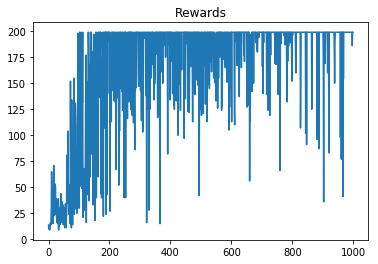

In [52]:
main()

# Policy Gradient method for continuous action space (actor critic method)

In [66]:
class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True, zeros=False):
        if zeros:
            W = np.zeros((M1, M2)).astype(np.float32)
            self.W = tf.Variable(W)
        else:
            self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))

        self.params = [self.W]

        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f
      
    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [7]:
class PolicyModel:
    def __init__(self, ft, D, hidden_layer_sizes_mean=[], hidden_layer_sizes_var=[]):

        # save inputs for copy
        self.ft = ft
        self.D = D
        self.hidden_layer_sizes_mean = hidden_layer_sizes_mean
        self.hidden_layer_sizes_var = hidden_layer_sizes_var

        ##### model the mean #####
        self.mean_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_mean:
            layer = HiddenLayer(M1, M2)
            self.mean_layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, 1, lambda x: x, use_bias=False, zeros=True)
        self.mean_layers.append(layer)


        ##### model the variance #####
        self.var_layers = []
        M1 = D
        for M2 in hidden_layer_sizes_var:
            layer = HiddenLayer(M1, M2)
            self.var_layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, 1, tf.nn.softplus, use_bias=False, zeros=False)
        self.var_layers.append(layer)

        # gather params
        self.params = []
        for layer in (self.mean_layers + self.var_layers):
            self.params += layer.params

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.actions = tf.placeholder(tf.float32, shape=(None,), name='actions')
        self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages')

        def get_output(layers):
            Z = self.X
            for layer in layers:
                Z = layer.forward(Z)
            return tf.reshape(Z, [-1])

        # calculate output and cost
        mean = get_output(self.mean_layers)
        std = get_output(self.var_layers) + 1e-4 # smoothing

        # note: the 'variance' is actually standard deviation
        norm = tf.contrib.distributions.Normal(mean, std)
        self.predict_op = tf.clip_by_value(norm.sample(), -1, 1)

    def set_session(self, session):
        self.session = session

    def init_vars(self):
        init_op = tf.variables_initializer(self.params)
        self.session.run(init_op)

    # def partial_fit(self, X, actions, advantages):
    #   X = np.atleast_2d(X)
    #   X = self.ft.transform(X)

    #   actions = np.atleast_1d(actions)
    #   advantages = np.atleast_1d(advantages)
    #   self.session.run(
    #     self.train_op,
    #     feed_dict={
    #       self.X: X,
    #       self.actions: actions,
    #       self.advantages: advantages,
    #     }
    #   )

    def predict(self, X):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})

    def sample_action(self, X):
        p = self.predict(X)[0]
        # print("action:", p)
        return p

    def copy(self):
        clone = PolicyModel(self.ft, self.D, self.hidden_layer_sizes_mean, self.hidden_layer_sizes_mean)
        clone.set_session(self.session)
        clone.init_vars() # tf will complain if we don't do this
        clone.copy_from(self)
        return clone

    def copy_from(self, other):
        # collect all the ops
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        # now run them all
        self.session.run(ops)

    def perturb_params(self):
        ops = []
        for p in self.params:
            v = self.session.run(p)
            noise = np.random.randn(*v.shape) / np.sqrt(v.shape[0]) * 5.0
            if np.random.random() < 0.1:
            # with probability 0.1 start completely from scratch
                op = p.assign(noise)
            else:
                op = p.assign(v + noise)
            ops.append(op)
        self.session.run(ops)

In [57]:
def play_one(env, pmodel, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0

    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        # oddly, the mountain car environment requires the action to be in
        # an object where the actual action is stored in object[0]
        observation, reward, done, info = env.step([action])

        totalreward += reward
        iters += 1
    return totalreward

In [59]:
def play_multiple_episodes(env, T, pmodel, gamma, print_iters=False):
  totalrewards = np.empty(T)

  for i in range(T):
    totalrewards[i] = play_one(env, pmodel, gamma)

    if print_iters:
      print(i, "avg so far:", totalrewards[:(i+1)].mean())

  avg_totalrewards = totalrewards.mean()
  print("avg totalrewards:", avg_totalrewards)
  return avg_totalrewards


def random_search(env, pmodel, gamma):
  totalrewards = []
  best_avg_totalreward = float('-inf')
  best_pmodel = pmodel
  num_episodes_per_param_test = 3
  for t in range(100):
    tmp_pmodel = best_pmodel.copy()

    tmp_pmodel.perturb_params()

    avg_totalrewards = play_multiple_episodes(
      env,
      num_episodes_per_param_test,
      tmp_pmodel,
      gamma
    )
    totalrewards.append(avg_totalrewards)

    if avg_totalrewards > best_avg_totalreward:
      best_pmodel = tmp_pmodel
      best_avg_totalreward = avg_totalrewards
  return totalrewards, best_pmodel


def main():
  env = gym.make('MountainCarContinuous-v0')
  ft = FeatureTransformer(env, n_components=100)
  D = ft.dimensions
  pmodel = PolicyModel(ft, D, [], [])
  # init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  # session.run(init)
  pmodel.set_session(session)
  pmodel.init_vars()
  gamma = 0.99

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  totalrewards, pmodel = random_search(env, pmodel, gamma)
  print("max reward:", np.max(totalrewards))

  # play 100 episodes and check the average
  avg_totalrewards = play_multiple_episodes(env, 100, pmodel, gamma, print_iters=True)
  print("avg reward over 100 episodes with best models:", avg_totalrewards)

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


avg totalrewards: -45.459748405433
avg totalrewards: -64.14013159605372
avg totalrewards: -97.27918101762145
avg totalrewards: -87.9183139142769
avg totalrewards: -52.815443168657254
avg totalrewards: -56.70080574465566
avg totalrewards: -98.1334976198089
avg totalrewards: -31.614367607308242
avg totalrewards: -54.35419685434596
avg totalrewards: -77.08961632370328
avg totalrewards: -73.86531621066682
avg totalrewards: -96.59331337127078
avg totalrewards: -27.87638098629682
avg totalrewards: -68.68846472858883
avg totalrewards: -32.2700311966699
avg totalrewards: -75.30959581339395
avg totalrewards: -20.80702061641973
avg totalrewards: -17.120457172996073
avg totalrewards: -26.280812832291293
avg totalrewards: -1.3626086329551053
avg totalrewards: -5.466084046383519
avg totalrewards: -5.086809965407301
avg totalrewards: -6.347542110533524
avg totalrewards: -2.0519538828891415
avg totalrewards: -41.05802598239529
avg totalrewards: -3.1295079823644616
avg totalrewards: -1.254949913397924

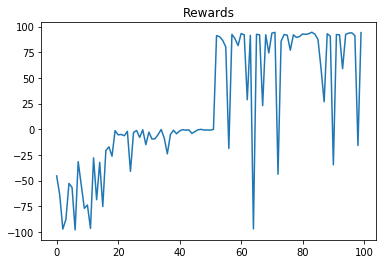

In [67]:
main()

# Value function instead of mountain climbing (intelligent search)

In [71]:
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True, zeros=False):
    if zeros:
      W = np.zeros((M1, M2), dtype=np.float32)
    else:
      W = tf.random_normal(shape=(M1, M2)) * np.sqrt(2. / M1, dtype=np.float32)
    self.W = tf.Variable(W)

    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))

    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a)


# approximates pi(a | s)
class PolicyModel:
  def __init__(self, D, ft, hidden_layer_sizes=[]):
    self.ft = ft

    ##### hidden layers #####
    M1 = D
    self.hidden_layers = []
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.hidden_layers.append(layer)
      M1 = M2

    # final layer mean
    self.mean_layer = HiddenLayer(M1, 1, lambda x: x, use_bias=False, zeros=True)

    # final layer variance
    self.stdv_layer = HiddenLayer(M1, 1, tf.nn.softplus, use_bias=False, zeros=False)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.actions = tf.placeholder(tf.float32, shape=(None,), name='actions')
    self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages')

    # get final hidden layer
    Z = self.X
    for layer in self.hidden_layers:
      Z = layer.forward(Z)

    # calculate output and cost
    mean = self.mean_layer.forward(Z)
    stdv = self.stdv_layer.forward(Z) + 1e-5 # smoothing

    # make them 1-D
    mean = tf.reshape(mean, [-1])
    stdv = tf.reshape(stdv, [-1]) 

    norm = tf.contrib.distributions.Normal(mean, stdv)
    self.predict_op = tf.clip_by_value(norm.sample(), -1, 1)

    log_probs = norm.log_prob(self.actions)
    cost = -tf.reduce_sum(self.advantages * log_probs + 0.1*norm.entropy())
    self.train_op = tf.train.AdamOptimizer(1e-3).minimize(cost)

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, actions, advantages):
    X = np.atleast_2d(X)
    X = self.ft.transform(X)
    
    actions = np.atleast_1d(actions)
    advantages = np.atleast_1d(advantages)
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: X,
        self.actions: actions,
        self.advantages: advantages,
      }
    )

  def predict(self, X):
    X = np.atleast_2d(X)
    X = self.ft.transform(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def sample_action(self, X):
    p = self.predict(X)[0]
    return p
# approximates V(s)
class ValueModel:
  def __init__(self, D, ft, hidden_layer_sizes=[]):
    self.ft = ft
    self.costs = []

    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    layer = HiddenLayer(M1, 1, lambda x: x)
    self.layers.append(layer)

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = tf.reshape(Z, [-1]) # the output
    self.predict_op = Y_hat

    cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
    self.cost = cost
    self.train_op = tf.train.AdamOptimizer(1e-1).minimize(cost)

  def set_session(self, session):
    self.session = session

  def partial_fit(self, X, Y):
    X = np.atleast_2d(X)
    X = self.ft.transform(X)
    Y = np.atleast_1d(Y)
    self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})
    cost = self.session.run(self.cost, feed_dict={self.X: X, self.Y: Y})
    self.costs.append(cost)

  def predict(self, X):
    X = np.atleast_2d(X)
    X = self.ft.transform(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})


def play_one_td(env, pmodel, vmodel, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0

  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = pmodel.sample_action(observation)
    prev_observation = observation
    observation, reward, done, info = env.step([action])

    totalreward += reward

    # update the models
    V_next = vmodel.predict(observation)
    G = reward + gamma*V_next
    advantage = G - vmodel.predict(prev_observation)
    pmodel.partial_fit(prev_observation, action, advantage)
    vmodel.partial_fit(prev_observation, G)

    iters += 1

  return totalreward, iters


def main():
  env = gym.make('MountainCarContinuous-v0')
  ft = FeatureTransformer(env, n_components=100)
  D = ft.dimensions
  pmodel = PolicyModel(D, ft, [])
  vmodel = ValueModel(D, ft, [])
  init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  session.run(init)
  pmodel.set_session(session)
  vmodel.set_session(session)
  gamma = 0.95

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)

  N = 50
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    totalreward, num_steps = play_one_td(env, pmodel, vmodel, gamma)
    totalrewards[n] = totalreward
    if n % 1 == 0:
      print("episode:", n, "total reward: %.1f" % totalreward, "num steps: %d" % num_steps, "avg reward (last 100): %.1f" % totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

#  plot_running_avg(totalrewards)
#  plot_cost_to_go(env, vmodel)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


episode: 0 total reward: 67.0 num steps: 471 avg reward (last 100): 67.0
episode: 1 total reward: 78.5 num steps: 273 avg reward (last 100): 72.7
episode: 2 total reward: 59.1 num steps: 569 avg reward (last 100): 68.2
episode: 3 total reward: 54.2 num steps: 578 avg reward (last 100): 64.7
episode: 4 total reward: 64.9 num steps: 424 avg reward (last 100): 64.7
episode: 5 total reward: 60.4 num steps: 490 avg reward (last 100): 64.0
episode: 6 total reward: 75.2 num steps: 322 avg reward (last 100): 65.6
episode: 7 total reward: 86.4 num steps: 174 avg reward (last 100): 68.2
episode: 8 total reward: 79.7 num steps: 256 avg reward (last 100): 69.5
episode: 9 total reward: 86.9 num steps: 160 avg reward (last 100): 71.2
episode: 10 total reward: 64.5 num steps: 426 avg reward (last 100): 70.6
episode: 11 total reward: 85.7 num steps: 193 avg reward (last 100): 71.9
episode: 12 total reward: 83.8 num steps: 206 avg reward (last 100): 72.8
episode: 13 total reward: 73.8 num steps: 316 av

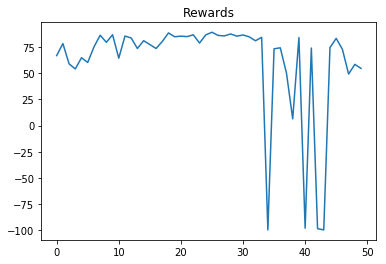

NameError: name 'plot_running_avg' is not defined

In [72]:
main()

# Deep Q-learning

In [8]:
# a version of HiddenLayer that keeps track of params
class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
            self.params.append(self.b)
        self.f = f

    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [54]:
class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
        self.K = K

        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, K, lambda x: x)
        self.layers.append(layer)

        # collect params for copy
        self.params = []
        for layer in self.layers:
            self.params += layer.params

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        self.predict_op = Y_hat

        selected_action_values = tf.reduce_sum(
          Y_hat * tf.one_hot(self.actions, K),
          reduction_indices=[1]
        )
        
        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

        # create replay memory
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma

    def set_session(self, session):
        self.session = session
        
    def copy_from(self, other):
        # collect all the ops
        ops = []
        my_params = self.params
        other_params = other.params
        for p, q in zip(my_params, other_params):
            actual = self.session.run(q)
            op = p.assign(actual)
            ops.append(op)
        # now run them all
        self.session.run(ops)
        
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})
    
    def train(self, target_network):
        # sample a random batch from buffer, do an iteration of GD
        if len(self.experience['s']) < self.min_experiences:
          # don't do anything if we don't have enough experience
          return

        # randomly select a batch
        idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
        # print("idx:", idx)
        states = [self.experience['s'][i] for i in idx]
        actions = [self.experience['a'][i] for i in idx]
        rewards = [self.experience['r'][i] for i in idx]
        next_states = [self.experience['s2'][i] for i in idx]
        dones = [self.experience['done'][i] for i in idx]
        next_Q = np.max(target_network.predict(next_states), axis=1)
        targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

        # call optimizer
        self.session.run(
          self.train_op,
          feed_dict={
            self.X: states,
            self.G: targets,
            self.actions: actions
          }
        )

    def add_experience(self, s, a, r, s2, done):
        if len(self.experience['s']) >= self.max_experiences:
            self.experience['s'].pop(0)
            self.experience['a'].pop(0)
            self.experience['r'].pop(0)
            self.experience['s2'].pop(0)
            self.experience['done'].pop(0)
        self.experience['s'].append(s)
        self.experience['a'].append(a)
        self.experience['r'].append(r)
        self.experience['s2'].append(s2)
        self.experience['done'].append(done)

    def sample_action(self, x, eps):
        if np.random.random() < eps:
            return np.random.choice(self.K)
        else:
            X = np.atleast_2d(x)
            return np.argmax(self.predict(X)[0])

In [85]:
M = DQN(10, 3, [8, 6, 4], 0.9)
X = np.random.rand(1, 10)
actions = np.array([0, 0, 1])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    s1 = sess.run(M.predict_op, feed_dict = {M.X: X})
    s2 = sess.run(M.selected_action_values,  feed_dict = {M.X: X, M.actions: actions})
    s3 = tf.one_hot([0, 0, 1], 3).eval()

In [ ]:
class DQN:
    def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
        self.K = K

        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, K, lambda x: x)
        self.layers.append(layer)

        # collect params for copy
        self.params = []
        for layer in self.layers:
            self.params += layer.params

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = Z
        self.predict_op = Y_hat

        selected_action_values = tf.reduce_sum(
          Y_hat * tf.one_hot(self.actions, K),
          reduction_indices=[1]
        )

        cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

        # create replay memory
        self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
        self.max_experiences = max_experiences
        self.min_experiences = min_experiences
        self.batch_sz = batch_sz
        self.gamma = gamma

  def set_session(self, session):
    self.session = session

  def copy_from(self, other):
    # collect all the ops
    ops = []
    my_params = self.params
    other_params = other.params
    for p, q in zip(my_params, other_params):
      actual = self.session.run(q)
      op = p.assign(actual)
      ops.append(op)
    # now run them all
    self.session.run(ops)

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def train(self, target_network):
    # sample a random batch from buffer, do an iteration of GD
    if len(self.experience['s']) < self.min_experiences:
      # don't do anything if we don't have enough experience
      return

    # randomly select a batch
    idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
    # print("idx:", idx)
    states = [self.experience['s'][i] for i in idx]
    actions = [self.experience['a'][i] for i in idx]
    rewards = [self.experience['r'][i] for i in idx]
    next_states = [self.experience['s2'][i] for i in idx]
    dones = [self.experience['done'][i] for i in idx]
    next_Q = np.max(target_network.predict(next_states), axis=1)
    targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

    # call optimizer
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: states,
        self.G: targets,
        self.actions: actions
      }
    )

  def add_experience(self, s, a, r, s2, done):
    if len(self.experience['s']) >= self.max_experiences:
      self.experience['s'].pop(0)
      self.experience['a'].pop(0)
      self.experience['r'].pop(0)
      self.experience['s2'].pop(0)
      self.experience['done'].pop(0)
    self.experience['s'].append(s)
    self.experience['a'].append(a)
    self.experience['r'].append(r)
    self.experience['s2'].append(s2)
    self.experience['done'].append(done)

  def sample_action(self, x, eps):
    if np.random.random() < eps:
      return np.random.choice(self.K)
    else:
      X = np.atleast_2d(x)
      return np.argmax(self.predict(X)[0])

In [10]:
# a version of HiddenLayer that keeps track of params
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
    self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
    self.params = [self.W]
    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))
      self.params.append(self.b)
    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a)


class DQN:
  def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
    self.K = K

    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    layer = HiddenLayer(M1, K, lambda x: x)
    self.layers.append(layer)

    # collect params for copy
    self.params = []
    for layer in self.layers:
      self.params += layer.params

    # inputs and targets
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.G = tf.placeholder(tf.float32, shape=(None,), name='G')
    self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = Z
    self.predict_op = Y_hat

    selected_action_values = tf.reduce_sum(
      Y_hat * tf.one_hot(self.actions, K),
      reduction_indices=[1]
    )

    cost = tf.reduce_sum(tf.square(self.G - selected_action_values))
    self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
    # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

    # create replay memory
    self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.batch_sz = batch_sz
    self.gamma = gamma

  def set_session(self, session):
    self.session = session

  def copy_from(self, other):
    # collect all the ops
    ops = []
    my_params = self.params
    other_params = other.params
    for p, q in zip(my_params, other_params):
      actual = self.session.run(q)
      op = p.assign(actual)
      ops.append(op)
    # now run them all
    self.session.run(ops)

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def train(self, target_network):
    # sample a random batch from buffer, do an iteration of GD
    if len(self.experience['s']) < self.min_experiences:
      # don't do anything if we don't have enough experience
      return

    # randomly select a batch
    idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
    # print("idx:", idx)
    states = [self.experience['s'][i] for i in idx]
    actions = [self.experience['a'][i] for i in idx]
    rewards = [self.experience['r'][i] for i in idx]
    next_states = [self.experience['s2'][i] for i in idx]
    dones = [self.experience['done'][i] for i in idx]
    next_Q = np.max(target_network.predict(next_states), axis=1)
    targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

    # call optimizer
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: states,
        self.G: targets,
        self.actions: actions
      }
    )

  def add_experience(self, s, a, r, s2, done):
    if len(self.experience['s']) >= self.max_experiences:
      self.experience['s'].pop(0)
      self.experience['a'].pop(0)
      self.experience['r'].pop(0)
      self.experience['s2'].pop(0)
      self.experience['done'].pop(0)
    self.experience['s'].append(s)
    self.experience['a'].append(a)
    self.experience['r'].append(r)
    self.experience['s2'].append(s2)
    self.experience['done'].append(done)

  def sample_action(self, x, eps):
    if np.random.random() < eps:
      return np.random.choice(self.K)
    else:
      X = np.atleast_2d(x)
      return np.argmax(self.predict(X)[0])


def play_one(env, model, tmodel, eps, gamma, copy_period):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    totalreward += reward
    if done:
      reward = -200

    # update the model
    model.add_experience(prev_observation, action, reward, observation, done)
    model.train(tmodel)

    iters += 1

    if iters % copy_period == 0:
      tmodel.copy_from(model)

  return totalreward


def main():
  env = gym.make('CartPole-v0')
  gamma = 0.99
  copy_period = 50

  D = len(env.observation_space.sample())
  K = env.action_space.n
  sizes = [200,200]
  model = DQN(D, K, sizes, gamma)
  tmodel = DQN(D, K, sizes, gamma)
  init = tf.global_variables_initializer()
  session = tf.InteractiveSession()
  session.run(init)
  model.set_session(session)
  tmodel.set_session(session)


  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)


  N = 1000
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

 # plot_running_avg(totalrewards)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


episode: 0 total reward: 23.0 eps: 1.0 avg reward (last 100): 23.0
episode: 100 total reward: 20.0 eps: 0.09950371902099892 avg reward (last 100): 127.8019801980198
episode: 200 total reward: 200.0 eps: 0.07053456158585983 avg reward (last 100): 167.06930693069307
episode: 300 total reward: 25.0 eps: 0.0576390417704235 avg reward (last 100): 153.17821782178217
episode: 400 total reward: 200.0 eps: 0.04993761694389223 avg reward (last 100): 136.41584158415841
episode: 500 total reward: 64.0 eps: 0.04467670516087703 avg reward (last 100): 140.1089108910891
episode: 600 total reward: 200.0 eps: 0.04079085082240021 avg reward (last 100): 140.79207920792078
episode: 700 total reward: 194.0 eps: 0.0377694787300249 avg reward (last 100): 97.95049504950495
episode: 800 total reward: 200.0 eps: 0.03533326266687867 avg reward (last 100): 149.37623762376236
episode: 900 total reward: 183.0 eps: 0.03331483023263848 avg reward (last 100): 120.26732673267327
avg reward for last 100 episodes: 106.79


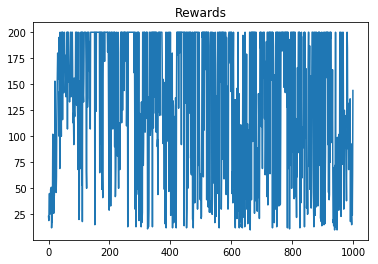

In [11]:
main()